In [1]:
#!/usr/bin/env python
from math import ceil
from random import uniform
import argparse
import os

import tensorflow as tf

from adain.nn import build_vgg, vgg_layer_params, build_decoder
from adain.norm import adain
from adain.util import get_params
from adain.weights import open_weights

import numpy as np
import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu


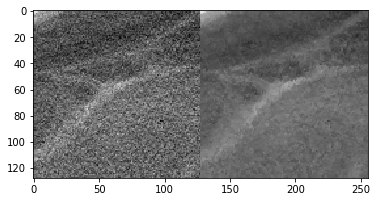

In [23]:
index = random.randint(0, len(x_array))
plt.imshow(np.concatenate([x_array[index, :, :, 0].astype('float32'), y_array[index, :, :, 0].astype('float32')]).T, cmap='gray')

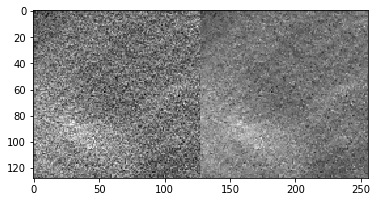

In [26]:
index = 5
plt.imshow(np.concatenate([x[index, :, :, 0].astype('float32'), y[index, :, :, 0].astype('float32')]).T, cmap='gray')

In [33]:
x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")

def get_my_batch():
    global x_array, y_array
    
    perm    = np.random.permutation(len(x_array))
    x_array = np.array(x_array)[perm]
    y_array = np.array(y_array)[perm]
    
    content_images = []
    style_images   = []
    
    for i in range(8):
        temp = [x_array[i, :, :, 0], x_array[i, :, :, 0], x_array[i, :, :, 0]]
        content_images.append(temp)
        
        temp = [y_array[i, :, :, 0], y_array[i, :, :, 0], y_array[i, :, :, 0]]
        style_images.append(temp)
       
    #content_images = x_array[:8, :, :, 0]
    #style_images   = y_array[:8, :, :, 0]
    
    #content_images = np.concatenate([content_images, content_images, content_images], axis=-1)
    #style_images   = np.concatenate([style_images, style_images, style_images], axis=-1)
    
    return np.array(content_images), np.array(style_images)

x, y = get_my_batch()

print(x.shape, y.shape)

(8, 3, 128, 128) (8, 3, 128, 128)


In [2]:
# Train Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")

def get_my_batch():
    global x_array, y_array
    
    perm    = np.random.permutation(len(x_array))
    x_array = np.array(x_array)[perm]
    y_array = np.array(y_array)[perm]
    
    content_images = []
    style_images   = []
    
    for i in range(8):
        temp = [x_array[i, :, :, 0], x_array[i, :, :, 0], x_array[i, :, :, 0]]
        content_images.append(temp)
        
        temp = [y_array[i, :, :, 0], y_array[i, :, :, 0], y_array[i, :, :, 0]]
        style_images.append(temp)
       
    #content_images = x_array[:8, :, :, 0]
    #style_images   = y_array[:8, :, :, 0]
    
    #content_images = np.concatenate([content_images, content_images, content_images], axis=-1)
    #style_images   = np.concatenate([style_images, style_images, style_images], axis=-1)
    
    return np.array(content_images), np.array(style_images)
    

def train(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=False,
        optimizer='adam',
        learning_rate=1e-4,
        learning_rate_decay=5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=1e-2,
        content_weight=1,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)

    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)

    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)

    with open_weights(vgg) as w:
        vgg = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_layers = {layer: vgg[layer] for layer in style_layers}
    style_targets = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    loss = content_loss + tf.reduce_sum(list(style_losses.values()))

    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    loss += tv_loss


    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        if resume:
            latest = tf.train.latest_checkpoint(checkpoint_dir)
            saver.restore(sess, latest)
        else:
            sess.run(tf.global_variables_initializer())

        coord   = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        with coord.stop_on_exception():
            while not coord.should_stop():
                content_batch, style_batch = get_my_batch()
                #content_batch, style_batch = sess.run(batch)

                # step 1
                # encode content and style images,
                # compute target style activations,
                # run content and style through AdaIN
                content_batch_encoded = sess.run(encoder, feed_dict={
                    images: content_batch
                })

                style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
                    images: style_batch
                })

                output_batch_encoded = sess.run(output_encoded, feed_dict={
                    content_encoded: content_batch_encoded,
                    style_encoded: style_batch_encoded
                })

                # step 2
                # run the output batch through the decoder, compute loss
                feed_dict = {
                    output_encoded: output_batch_encoded,
                    # "We use the AdaIN output as the content target, instead of
                    # the commonly used feature responses of the content image"
                    content_target: output_batch_encoded
                }
                for layer in style_targets:
                    feed_dict[style_targets[layer]] = style_target_vals[layer]

                fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step]
                result = sess.run(fetches, feed_dict=feed_dict)
                _, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i = result

                if i % print_every == 0:
                    style_loss_val = sum(style_loss_vals.values())
                    style_loss_vals = '\t'.join(sorted(['%s = %0.4f' % (name, val) for name, val in style_loss_vals.items()]))
                    print(i,
                        'loss = %0.4f' % loss_val,
                        'content = %0.4f' % content_loss_val,
                        'style = %0.4f' % style_loss_val,
                        style_loss_vals,
                        'tv = %0.4f' % tv_loss_val, sep='\t')

                if i % save_every == 0:
                    print('Saving checkpoint')
                    saver.save(sess, os.path.join(checkpoint_dir, 'adain'), global_step=i)

        coord.join(threads)
        saver.save(sess, os.path.join(checkpoint_dir, 'adain-final'))


def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        mean_loss /= n
        std_loss /= n

        losses[layer] = (mean_loss + std_loss) * weight
    return losses




# if __name__ == '__main__':
#     params = get_params(train)

#     parser = argparse.ArgumentParser(description='AdaIN Style Transfer Training')

#     # general
#     parser.add_argument('--content_dir', default=params['content_dir'],
#         help='A directory with TFRecords files containing content images for training')
#     parser.add_argument('--style_dir', default=params['style_dir'],
#         help='A directory with TFRecords files containing style images for training')
#     parser.add_argument('--vgg', default=params['vgg'],
#         help='Path to the weights of the VGG19 network')
#     parser.add_argument('--checkpoint_dir', default=params['checkpoint_dir'],
#         help='Name of the checkpoint directory')
#     parser.add_argument('--decoder_activation', default=params['decoder_activation'],
#         help='Activation function in the decoder')
#     parser.add_argument('--gpu', default=params['gpu'], type=int,
#         help='Zero-indexed ID of the GPU to use')

#     # preprocessing
#     parser.add_argument('--initial_size', default=params['initial_size'],
#         type=int, help='Initial size of training images')
#     parser.add_argument('--random_crop_size', default=params['random_crop_size'], type=int,
#         help='Images will be randomly cropped to this size')

#     # training options
#     parser.add_argument('--resume', action='store_true',
#         help='If true, resume training from the last checkpoint')
#     parser.add_argument('--optimizer', default=params['optimizer'],
#         help='Optimizer used, adam or SGD')
#     parser.add_argument('--learning_rate', default=params['learning_rate'],
#         type=float, help='Learning rate')
#     parser.add_argument('--learning_rate_decay', default=params['learning_rate_decay'],
#         type=float, help='Learning rate decay')
#     parser.add_argument('--momentum', default=params['momentum'],
#         type=float, help='Momentum')
#     parser.add_argument('--batch_size', default=params['batch_size'],
#         type=int, help='Batch size')
#     parser.add_argument('--num_epochs', default=params['num_epochs'],
#         type=int, help='Number of epochs')
#     parser.add_argument('--content_layer', default=params['content_layer'],
#         help='Target content layer used to compute the loss')
#     parser.add_argument('--style_layers', default=params['style_layers'],
#         help='Target style layers used to compute the loss')
#     parser.add_argument('--tv_weight', default=params['tv_weight'],
#         type=float, help='Weight of the Total Variation loss')
#     parser.add_argument('--style_weight', default=params['style_weight'],
#         type=float, help='Weight of style loss')
#     parser.add_argument('--content_weight', default=params['content_weight'],
#         type=float, help='Weight of content loss')

#     parser.add_argument('--save_every', default=params['save_every'],
#         type=int, help='Save interval')
#     parser.add_argument('--print_every', default=params['print_every'],
#         type=int, help='Print interval')

#     args = parser.parse_args()
#     train(**vars(args))


In [ ]:
train()

10	loss = 5.6688	content = 0.4703	style = 5.1985	conv1_1 = 1.1955	conv2_1 = 1.1804	conv3_1 = 0.6179	conv4_1 = 2.2046	tv = 0.0000
20	loss = 1.1865	content = 0.1133	style = 1.0732	conv1_1 = 0.0487	conv2_1 = 0.1569	conv3_1 = 0.2881	conv4_1 = 0.5795	tv = 0.0000
30	loss = 2.0117	content = 0.2015	style = 1.8102	conv1_1 = 0.0548	conv2_1 = 0.1908	conv3_1 = 0.5339	conv4_1 = 1.0307	tv = 0.0000
40	loss = 3.2453	content = 0.3583	style = 2.8870	conv1_1 = 0.0502	conv2_1 = 0.1913	conv3_1 = 0.8135	conv4_1 = 1.8321	tv = 0.0000
50	loss = 1.6053	content = 0.1649	style = 1.4403	conv1_1 = 0.0509	conv2_1 = 0.1700	conv3_1 = 0.3760	conv4_1 = 0.8435	tv = 0.0000
60	loss = 1.6152	content = 0.1647	style = 1.4505	conv1_1 = 0.0490	conv2_1 = 0.1666	conv3_1 = 0.3924	conv4_1 = 0.8425	tv = 0.0000
70	loss = 1.4507	content = 0.1567	style = 1.2940	conv1_1 = 0.0439	conv2_1 = 0.1426	conv3_1 = 0.3060	conv4_1 = 0.8014	tv = 0.0000
80	loss = 2.0660	content = 0.2115	style = 1.8545	conv1_1 = 0.0528	conv2_1 = 0.1876	conv3_1 = 0.53

650	loss = 1.4415	content = 0.1406	style = 1.3009	conv1_1 = 0.0560	conv2_1 = 0.1831	conv3_1 = 0.3427	conv4_1 = 0.7192	tv = 0.0000
660	loss = 2.3639	content = 0.2534	style = 2.1105	conv1_1 = 0.0509	conv2_1 = 0.1812	conv3_1 = 0.5824	conv4_1 = 1.2961	tv = 0.0000
670	loss = 1.0053	content = 0.0893	style = 0.9160	conv1_1 = 0.0550	conv2_1 = 0.1705	conv3_1 = 0.2337	conv4_1 = 0.4568	tv = 0.0000
680	loss = 1.5023	content = 0.1492	style = 1.3531	conv1_1 = 0.0496	conv2_1 = 0.1656	conv3_1 = 0.3747	conv4_1 = 0.7632	tv = 0.0000
690	loss = 1.9481	content = 0.1937	style = 1.7544	conv1_1 = 0.0557	conv2_1 = 0.1965	conv3_1 = 0.5117	conv4_1 = 0.9904	tv = 0.0000
700	loss = 1.2520	content = 0.1188	style = 1.1332	conv1_1 = 0.0515	conv2_1 = 0.1688	conv3_1 = 0.3050	conv4_1 = 0.6078	tv = 0.0000
710	loss = 0.9097	content = 0.0813	style = 0.8283	conv1_1 = 0.0479	conv2_1 = 0.1485	conv3_1 = 0.2157	conv4_1 = 0.4162	tv = 0.0000
720	loss = 1.4146	content = 0.1383	style = 1.2764	conv1_1 = 0.0495	conv2_1 = 0.1652	conv3_